In [1]:
# Import packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nemed
from nemed.downloader import download_current_aemo_cdeii_summary
import pprint
import ppa, residuals, tariffs, hybrid

# Set up variables for loading csv w/ correct data types:
type_dict = {
    'DateTime' : 'str',
    'total_load' : 'float',
    'Wind' : 'float',
    'Solar' : 'float',
    '20/80' : 'float',
    '30/70' : 'float',
    '40/60' : 'float',
    '50/50' : 'float',
    '60/40' : 'float',
    '70/30' : 'float',
    '80/20' : 'float'
}
parse_dates = ['DateTime']

In [45]:
# Import load profiles and pricing data

# 1. One year of load and generation data
profiles = pd.read_csv('/Users/elliekallmier/Desktop/RA Work/mirvac/ppa_tool_python/MSAT-PPA-Python-master/data/cleaned_profiles.csv', dtype=type_dict, parse_dates=parse_dates)

# 2. One year of wholesale price data
price_data = pd.read_csv('/Users/elliekallmier/Desktop/RA Work/mirvac/ppa_tool_python/MSAT-PPA-Python-master/data/qld_prices_2021.csv')
price_data['ts'] = pd.to_datetime(price_data['SETTLEMENTDATE'])
price_data = price_data.set_index('ts').resample('30min').mean()
price_data['DateTime'] = pd.date_range("2021-01-01 00:30", periods=17521, freq="30min")
price_data = price_data.reset_index()
prices = price_data[['DateTime', 'RRP']]    # cleaned up pricing data for QLD 2021

In [46]:
# testing hyrbid functions:
ids = ['DateTime', 'total_load', 'Wind', 'Solar', '20/80']
profiles = profiles[ids]
print(profiles.columns)
# gen_profiles = hybrid.create_hybrid(profiles, [("Wind", 0.25), ("Solar", 0.75)], "25/75")

# ids = ['Wind', 'Solar', '25/75']
# scaled_profiles = hybrid.scale_gen_profile(profiles, ids, scaling_period="Quarterly", scaling_factor=1)


Index(['DateTime', 'total_load', 'Wind', 'Solar', '20/80'], dtype='object')


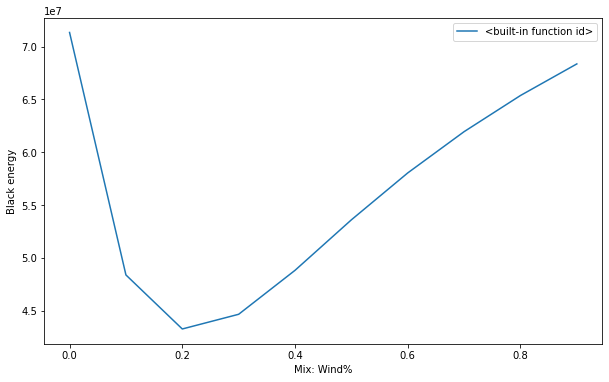

In [27]:
black_energy = []

for i in np.arange(0, 1, 0.1):
    name = str(i*100) + '/' + str((1-i)*100)
    gen_profiles = hybrid.create_hybrid(profiles, [('Wind', i), ('Solar', (1-i))], name)
    gen_profiles = hybrid.scale_gen_profile(gen_profiles, ['Wind', 'Solar', name], scaling_period='Yearly')
    residual_profile = residuals.calc(gen_profiles, load_id='total_load', generator_id=name)
    resi = pd.DataFrame(data=residual_profile).set_index('DateTime')
    black_energy.append(np.sum(resi['Black']))

#print(black_energy)


plt.figure(figsize=(10,6))
plt.plot(np.arange(0, 1, 0.1), black_energy, label=id)
plt.xlabel('Mix: Wind%')
plt.ylabel('Black energy')
plt.legend(loc='upper right')
plt.show()

In [71]:
black_energy = []
for i in np.arange(0.1, 1, 0.1):
    for j in np.arange(0.1, 1, 0.1):
        for k in np.arange(0.1, 1., 0.1):
            if (i+j+k)==1:
                name = str(i*100) + '/' + str(j*100) + '/' + str(k*100)
                gen_profiles = hybrid.create_hybrid(profiles, [('Wind', i), ('Solar', j), ('20/80', k)], name)
                residual_profile = residuals.calc(gen_profiles, load_id='total_load', generator_id=name)
                resi = pd.DataFrame(data=residual_profile).set_index('DateTime')
                black_energy.append(np.sum(resi['Black']))

#print(black_energy)

# Write up objective function for optimisation?
def objective(x, profs, ids):
    i, j, k = x[0], x[1], x[2]
    profiles, gen_ids = params
    name = f'{i:.0%}/{j:.0%}/{k:.0%}'
    hybrid_profile = hybrid.create_hybrid(profiles, [(gen_ids[0], i), (gen_ids[1], j), (gen_ids[2], k)], name)
    hybrid_profile = hybrid.scale_gen_profile(hybrid_profile, ['Wind', 'Solar', name], scaling_period='Yearly')
    residual_profile = residuals.calc(hybrid_profile, load_id='total_load', generator_id=name)
    black_energy = (np.sum(residual_profile['Black']))
    load = np.sum(residual_profile['Load'])
    percent_black = black_energy/load
    return percent_black

mixes = [15/100, 80/100, 5/100]
params = profiles, ['Wind', 'Solar', '20/80']
match = objective(mixes, profiles, ['Wind', 'Solar', '20/80'])
print(f'{match:.0%}')



28%


In [43]:
params = profiles, ['Wind', 'Solar', '20/80']

from scipy import optimize
from scipy.optimize import Bounds, LinearConstraint, minimize

bounds = Bounds([0,0,0],[1,1,1])
linear_constr = LinearConstraint([[1,1,1],[1,1,1],[1,1,1]], [1,1,1], [1,1,1])
x0 = mixes

#res = minimize(objective, x0, params, method='trust-constr', constraints=linear_constr, bounds=bounds)


In [ ]:
bounds = [(0,1), (0,1)]
ids = ['Wind', 'Solar', '20/80']
profs = profiles
res_shgo = optimize.shgo(func=lambda x, profs=profs, ids=ids: objective(x, profs,ids), bounds=bounds)

ValueError: Argument Z must be 2-dimensional.

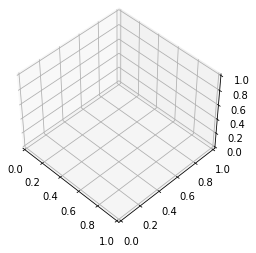

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(0, 1)
y = np.arange(0, 1)
z = np.arange(0, 1)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, objective(x, y, profiles, ids), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('function')
plt.show()

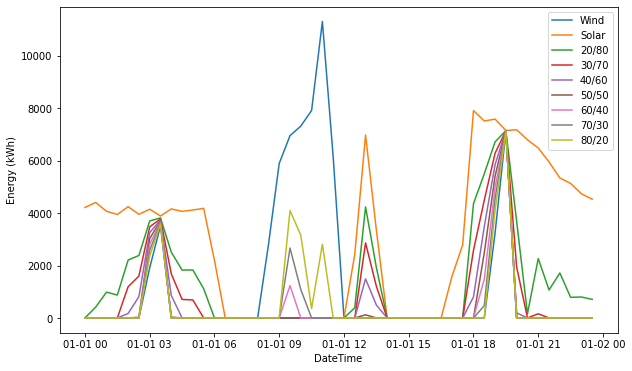

In [4]:
# 3. Calculate the residual profiles need for PPA and tariff calculations
residuals_dict = {}
re_gen_ids = ['Wind', 'Solar', '20/80', '30/70', '40/60', '50/50', '60/40', '70/30', '80/20']
for id in re_gen_ids:
    residual_profiles = residuals.calc(profiles, load_id='total_load', generator_id=id)
    resi = pd.DataFrame(data=residual_profiles).set_index('DateTime')
    residuals_dict[id] = resi

#resi.to_csv('data/residuals.csv')
# print('\n Load profiles used for cost calculations:')
# print(residual_profiles)

# 3(a). Plot Residuals
plt.figure(figsize=(10,6))
for id, data in residuals_dict.items():
    day_one = data.head(48)
    plt.plot(day_one.index, day_one['Black'], label=id)
plt.xlabel('DateTime')
plt.ylabel('Energy (kWh)')
plt.legend(loc='upper right')
plt.show()

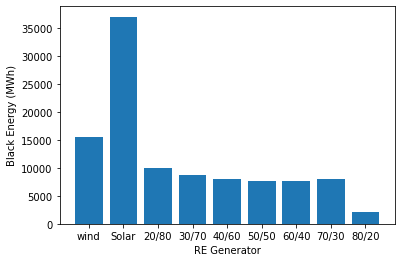

In [11]:
# 3(b). Find and plot total firming energy under different RE generator profiles
total_load_2021 = np.sum(profiles['total_load'])
firming_by_re_gen = {}
#percent_load_not_covered = {}
for id, data in residuals_dict.items():
    total_firming = np.sum(residuals_dict[id]['Black'])
    firming_by_re_gen[id] = total_firming / 1000
    #percent_load_not_covered[id] = total_firming / total_load_2021

plt.bar(range(len(firming_by_re_gen)), list(firming_by_re_gen.values()), align='center')
plt.xticks(range(len(firming_by_re_gen)), list(firming_by_re_gen.keys()))
plt.xlabel('RE Generator')
plt.ylabel('Black Energy (MWh)')
plt.show()

In [12]:
# 4. Calculate PPA costs
ppa_costs = ppa.calc(contract_type='Off-site - Contract for Difference',
                     ppa_volume='RE Uptill Load',  # In each 30 min interval the PPA volume is the lesser of generator
                                                   # or load volume.
                     contract_price=50.0,
                     wholesale_volume='RE Uptill Load',  # In each 30 min interval the volume bought from the wholesale
                                                         # market is less of generator or load volume.
                     residual_profiles=residual_profiles,
                     price_profile=prices['RRP']
                     )
print('\n PPA cost summary:')
pprint.pprint(ppa_costs)


 PPA cost summary:
{'Cost of Excess RE': 0.0,
 'Generation shortfall penalty payment': 0,
 'LGC purchase cost': 0,
 'LGC shortfall penalty payment': 0,
 'PPA': -2927545.5490892725,
 'Payment from Excess RE': 0,
 'Payment from wholesale of RE': 0.0,
 'Wholesale cost': 7101426.125256803}


In [13]:
# 5. Define tariffs
applicable_tariffs = pd.DataFrame({
    'Charge name': ['peak', 'off_peak'],
    'Charge Type': ['Energy', 'Energy'],
    'Volume Type': ['Energy ($/MWh)', 'Energy ($/MWh)'],
    'Rate': [85.0,65.0],
    'MLF': [1.0, 1.0],
    'DLF': [1.0, 1.0],
    'Start Month': [1, 1],
    'End Month': [12, 12],
    'Start Weekday': [1, 1],
    'End Weekday': [7, 7],
    'Start Hour': [7, 21],
    'End Hour': [20, 6]
})

In [14]:
# 6. Calculate Tariff costs
tariff_costs = tariffs.calc_tou_set(tou_set=applicable_tariffs, contract_type='Off-site - Contract for Difference',
                                    wholesale_volume='RE Uptill Load', load_profiles=residual_profiles)

print('\n Tariffs and costs summary:')
print(tariff_costs)


 Tariffs and costs summary:
  Charge name Charge Type     Volume Type  Rate  MLF  DLF  Start Month  \
0        peak      Energy  Energy ($/MWh)  85.0  1.0  1.0            1   
1    off_peak      Energy  Energy ($/MWh)  65.0  1.0  1.0            1   

   End Month  Start Weekday  End Weekday  Start Hour  End Hour Alt Load ID  \
0         12              1            7           7        20       Black   
1         12              1            7          21         6       Black   

            Cost  
0  133302.686499  
1   32426.295633  
